In [1]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Data Processing

Function to create a mask from annotations. The masks are not given in the form of pictures so we must create it from the annotations 

In [2]:
def create_mask(image_path, data, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    file_name = os.path.basename(image_path)
    image_id = None
    width, height = None, None
    
    for image_info in data['images']:
        if image_info['file_name'] == file_name:
            image_id = image_info['id']
            width = image_info['width']
            height = image_info['height']
            break
    
    if image_id is None:
        print(f"Image {file_name} not found in dataset.")
        return
    
    mask = np.zeros((height, width), dtype=np.uint8)
    
    for annotation in data['annotations']:
        if annotation['image_id'] == image_id:
            for segmentation in annotation['segmentation']:
                polygon = np.array(segmentation).reshape(-1, 2)
                cv2.fillPoly(mask, [polygon.astype(np.int32)], color=1)
    
    mask_path = os.path.join(output_dir, file_name.replace('.jpg.rf', '_mask.png'))
    Image.fromarray(mask * 255).save(mask_path)

Function to load annotations

In [3]:
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    return data

Function to get image and mask paths

In [4]:
def get_image_and_mask_paths(annotation_data, images_folder, masks_folder):
    image_paths = []
    mask_paths = []
    
    for image_info in annotation_data['images']:
        image_file_name = image_info['file_name']
        image_path = os.path.join(images_folder, image_file_name)
        image_paths.append(image_path)
        
        mask_file_name = image_file_name.replace('.jpg.rf', '_mask.png')
        mask_path = os.path.join(masks_folder, mask_file_name)
        mask_paths.append(mask_path)
        
    return image_paths, mask_paths

Function to load and preprocess images (resizing to 128 x 128 and normalizing by dividing by 255)

In [5]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  
    image = image / 255.0  
    return image

Function to load and preprocess masks. Some processing is also applied like before 

In [6]:

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  
    mask = tf.image.resize(mask, [128, 128])  
    mask = mask / 255.0  # Normalize to 0-1
    return mask

Function to create the TensorFlow dataset, which will be fed into the model 

In [7]:

def create_tf_dataset(image_paths, mask_paths):
    def load_and_preprocess_image(image_path, mask_path):
        image = load_image(image_path)
        mask = load_mask(mask_path)
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: tf.py_function(load_and_preprocess_image, [x, y], (tf.float32, tf.float32)))
    dataset = dataset.batch(16)  
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

Function to visualize an image and its mask

In [8]:
def visualize_image_and_mask(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path).convert('L')  # Convert to grayscale

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

Finally, getting all the paths, loading all the annotations and images and masks and then creating dataset arrays. At the end, they are visualized. We can see the input image and the corresponding mask that we derived from the annotations 

Image _annotations.coco.json not found in dataset.
Image _annotations.coco.json not found in dataset.
Image _annotations.coco.json not found in dataset.


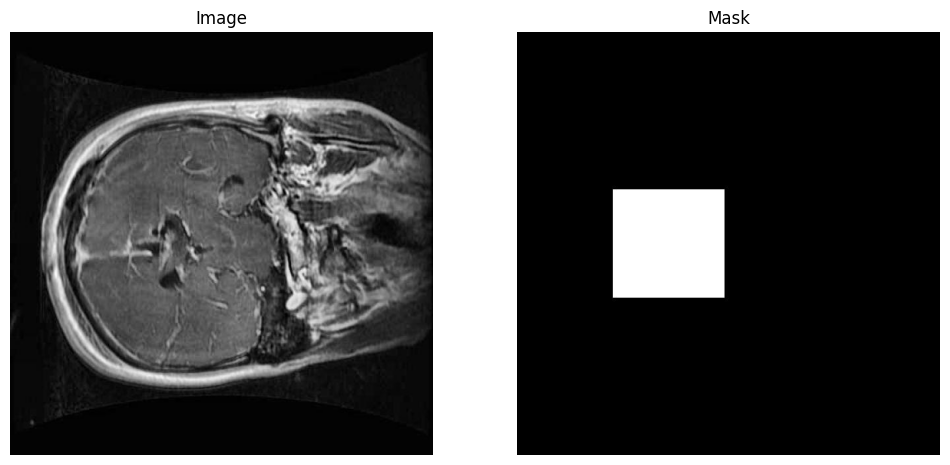

In [9]:
base_path = 'archive/'
train_folder = os.path.join(base_path, 'train')
valid_folder = os.path.join(base_path, 'valid')
test_folder = os.path.join(base_path, 'test')

output_train_folder = 'output/train'
output_valid_folder = 'output/valid'
output_test_folder = 'output/test'

# Load annotations
train_annotations = load_annotations(os.path.join(base_path, 'train/_annotations.coco.json'))
valid_annotations = load_annotations(os.path.join(base_path, 'valid/_annotations.coco.json'))
test_annotations = load_annotations(os.path.join(base_path, 'test/_annotations.coco.json'))

# Generate masks
for image_file in os.listdir(train_folder):
    create_mask(os.path.join(train_folder, image_file), train_annotations, output_train_folder)
for image_file in os.listdir(valid_folder):
    create_mask(os.path.join(valid_folder, image_file), valid_annotations, output_valid_folder)
for image_file in os.listdir(test_folder):
    create_mask(os.path.join(test_folder, image_file), test_annotations, output_test_folder)

# Get image and mask paths
train_image_paths, train_mask_paths = get_image_and_mask_paths(train_annotations, train_folder, output_train_folder)
valid_image_paths, valid_mask_paths = get_image_and_mask_paths(valid_annotations, valid_folder, output_valid_folder)
test_image_paths, test_mask_paths = get_image_and_mask_paths(test_annotations, test_folder, output_test_folder)

# Create TensorFlow datasets
train_dataset = create_tf_dataset(train_image_paths, train_mask_paths)
valid_dataset = create_tf_dataset(valid_image_paths, valid_mask_paths)
test_dataset = create_tf_dataset(test_image_paths, test_mask_paths)

# Visualize an example
test_image_path = train_image_paths[0]
test_mask_path = train_mask_paths[0]
visualize_image_and_mask(test_image_path, test_mask_path)



# Model 

Creating the model 

The model has 4 encoder blocks, 1 bottleneck convolution block, 4 decoder blocks, 1 output layer (sigmoid)

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    inp = Conv2D(num_filters, 3, padding="same")(inputs)
    inp = BatchNormalization()(inp)
    inp = Activation("relu")(inp)

    inp = Conv2D(num_filters, 3, padding="same")(inp)
    inp = BatchNormalization()(inp)
    inp = Activation("relu")(inp)

    return inp

def encoder_block(inputs, num_filters):
    inp = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(inp)
    return inp, p

def decoder_block(inputs, skip_features, num_filters):
    inp = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    inp = Concatenate()([inp, skip_features])
    inp = conv_block(inp, num_filters)
    return inp

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="unet")
    return model

In [11]:
model = build_unet((128, 128, 3))
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

Loss function

In [12]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

set learning rate and compile the model

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

lr = 1e-4

model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])


Set the callbacks

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

callbacks = [
        ModelCheckpoint("logs/model.h5", verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

Run for 50 epochs

In [15]:
history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/50
94/94 [==============================] - ETA: 0s - loss: 0.7493 - dice_coef: 0.2509
Epoch 1: val_loss improved from inf to 0.94121, saving model to logs\model.h5
94/94 [==============================] - 72s 679ms/step - loss: 0.7493 - dice_coef: 0.2509 - val_loss: 0.9412 - val_dice_coef: 0.0588 - lr: 1.0000e-04
Epoch 2/50
94/94 [==============================] - ETA: 0s - loss: 0.5794 - dice_coef: 0.4207
Epoch 2: val_loss did not improve from 0.94121
94/94 [==============================] - 47s 500ms/step - loss: 0.5794 - dice_coef: 0.4207 - val_loss: 0.9609 - val_dice_coef: 0.0391 - lr: 1.0000e-04
Epoch 3/50
94/94 [==============================] - ETA: 0s - loss: 0.4923 - dice_coef: 0.5079
Epoch 3: val_loss did not improve from 0.94121
94/94 [==============================] - 48s 516ms/step - loss: 0.4923 - dice_coef: 0.5079 - val_loss: 0.9539 - val_dice_coef: 0.0460 - lr: 1.0000e-04
Epoch 4/50
94/94 [==============================] - ETA: 0s - loss: 0.4196 - dice_coef: 0.

Evaluate the model and print the test loss and dice coeff. Gives us acceptable results

In [16]:
test_loss, test_metric = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Metric (Dice Coefficient): {test_metric}")


14/14 [==============================] - 5s 368ms/step - loss: 0.2499 - dice_coef: 0.7443
Test Loss: 0.2498701959848404
Test Metric (Dice Coefficient): 0.7442601323127747


Use the test images to create predictions for them

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def get_predictions(dataset, model):
    all_images = []
    all_true_masks = []
    all_predictions = []

    # Iterate over the entire dataset
    for images, true_masks in dataset:
        predictions = model.predict(images)
        all_images.append(images.numpy())  # Convert tensors to numpy arrays
        all_true_masks.append(true_masks.numpy())
        all_predictions.append(predictions)

    # Concatenate all batches to get a single array for each
    all_images = np.concatenate(all_images, axis=0)
    all_true_masks = np.concatenate(all_true_masks, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    return all_images, all_true_masks, all_predictions

# Get predictions for all test images
images, true_masks, predictions = get_predictions(test_dataset, model)


1/1 [==============================] - 0s 19ms/step


Some of the predictions are visualized in comparison with input image and true mask to see how effective our model is 

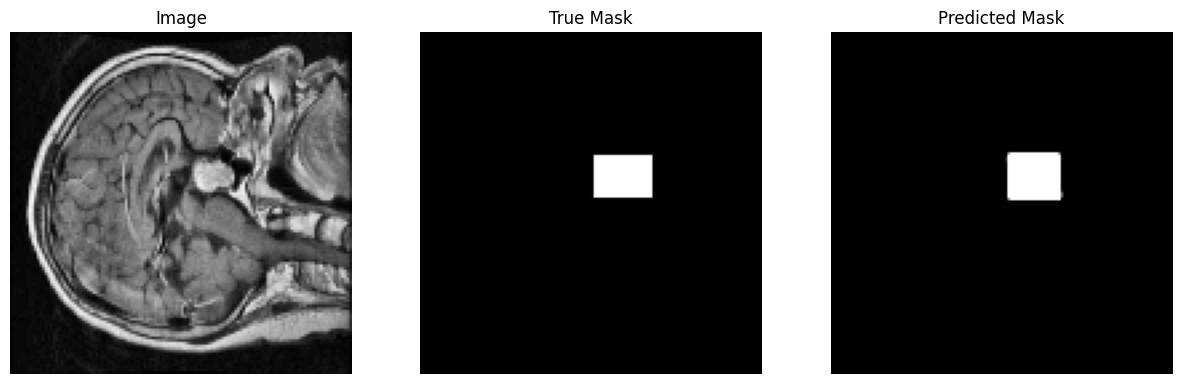

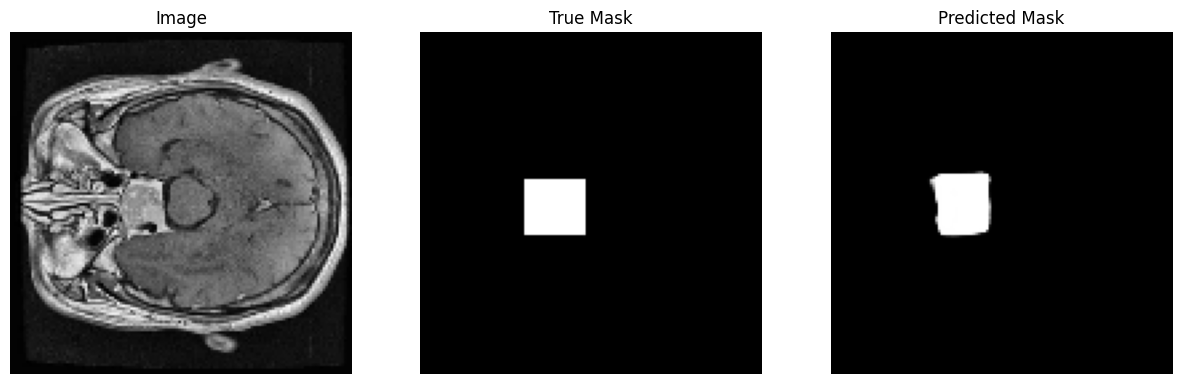

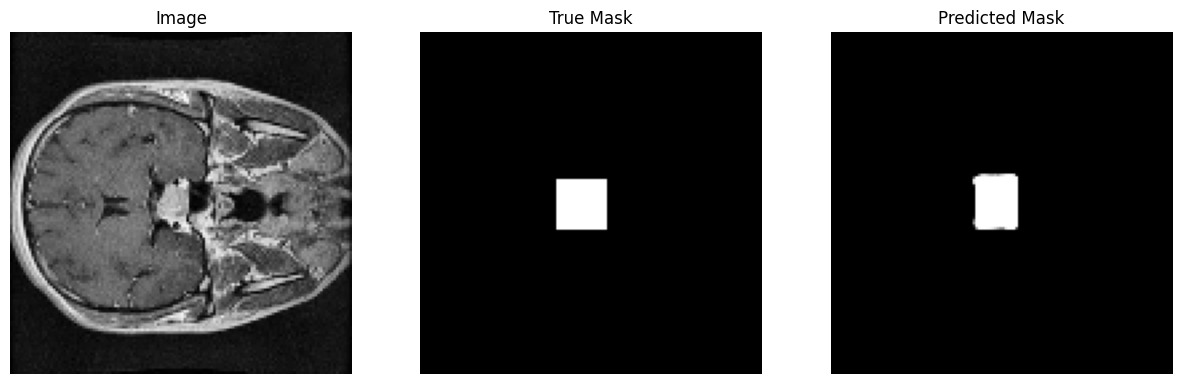

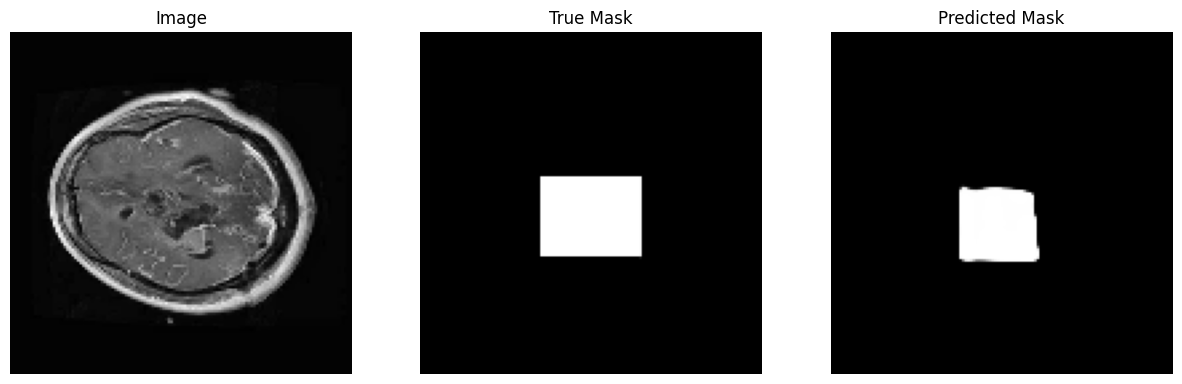

In [18]:
def visualize_predictions(images, true_masks, predictions, num_samples=4):
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Plot image
        plt.subplot(1, 3, 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
        plt.title("Image")
        plt.axis('off')

        # Plot true mask
        plt.subplot(1, 3, 2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(true_masks[i]), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.sigmoid(predictions[i])), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

# Visualize predictions
visualize_predictions(images, true_masks, predictions, num_samples=4)


The model history was saved so we can also see the model loss and dice coefficient vs epochs to see how our model progressed as the number of epochs increased 

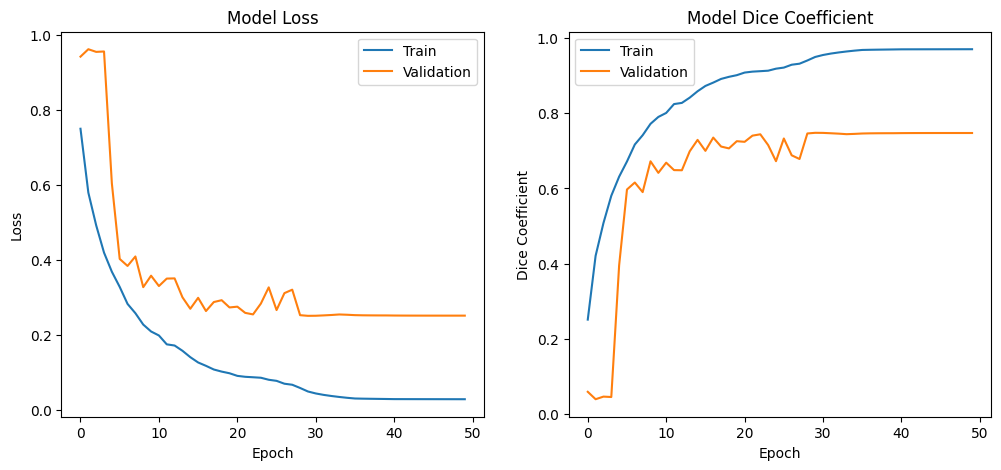

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend(['Train', 'Validation'])

    plt.show()

plot_history(history)


In [20]:
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score


Process the prediction data so we can use some of the built in metric functions from sklearn. Some processing includes converting continuous probability maps into binary masks. Also, we set that any prediction above the threshold is classified as target 1 and anything below is 0. 

In [21]:
def binarize_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(int)

# Apply binarization to predictions
predictions_binary = binarize_predictions(predictions)


In [22]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
import matplotlib.pyplot as plt
import tensorflow as tf

def binarize_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(int)

def compute_metrics(y_true, y_pred):
    # Convert tensors to numpy arrays if they are not already
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy()
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()
    
    # Binarize the true masks if they are not already binary
    y_true = (y_true > 0.5).astype(int)

    # Flatten arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute metrics
    f1_value = f1_score(y_true_flat, y_pred_flat, average='binary')
    precision_value = precision_score(y_true_flat, y_pred_flat, average='binary')
    recall_value = recall_score(y_true_flat, y_pred_flat, average='binary')
    jaccard_value = jaccard_score(y_true_flat, y_pred_flat, average='binary')

    return f1_value, precision_value, recall_value, jaccard_value



# Get predictions
images, true_masks, predictions = get_predictions(test_dataset, model)

# Binarize predictions
predictions_binary = binarize_predictions(predictions)

# Compute metrics
f1_value, precision_value, recall_value, jaccard_value = compute_metrics(true_masks, predictions_binary)

print(f'F1 Score: {f1_value:.4f}')
print(f'Precision: {precision_value:.4f}')
print(f'Recall: {recall_value:.4f}')
print(f'Jaccard Score: {jaccard_value:.4f}')



1/1 [==============================] - 0s 22ms/step
F1 Score: 0.7580
Precision: 0.8316
Recall: 0.6963
Jaccard Score: 0.6103


Save the predicted images 

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ensure the directory for saving masks exists
output_dir = 'predicted_masks'
os.makedirs(output_dir, exist_ok=True)

# Assume predictions_binary contains the predicted masks
# predictions_binary shape: (num_samples, height, width)

def save_masks_as_images(masks, output_dir):
    for i, mask in enumerate(masks):
        # Ensure the mask is in the correct format (0 or 255 for visualization)
        mask_image = (mask * 255).astype(np.uint8)

        # Add an extra dimension for the channel
        mask_image = np.expand_dims(mask_image, axis=-1)

        # Save the mask as a PNG file
        plt.imsave(f"{output_dir}/mask_{i}.png", mask_image.squeeze(), cmap='gray')

# Save the masks
save_masks_as_images(predictions_binary, output_dir)
